In [11]:
from neo4j import GraphDatabase, basic_auth
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm
import os

In [2]:
load_dotenv()
DB_HOST = os.getenv("NEO4J_HOST")
DB_PORT = os.getenv("NEO4J_PORT")
DB_USER = os.getenv("NEO4J_USER")
DB_PASS = os.getenv("NEO4J_PASS")

In [3]:
driver = GraphDatabase.driver(f"bolt://{DB_HOST}:{DB_PORT}", auth=basic_auth(DB_USER, DB_PASS))
driver

In [4]:
with driver.session() as session:
    result = session.run(f"""
        MATCH (n:Artist)-[:WORKED_IN]->(t:Track)
        WITH 
            n.main_id AS id, 
            avg(CASE WHEN t.artist_count = "1" THEN t.popularity ELSE NULL END) AS solo_pop,
            avg(CASE WHEN t.artist_count <> "1" THEN t.popularity ELSE NULL END) AS collab_pop
        WHERE collab_pop IS NOT NULL AND solo_pop <> 0 AND solo_pop IS NOT NULL
        WITH id, collab_pop / solo_pop AS pop_ratio
        WITH COLLECT(pop_ratio) AS pop_ratios
        WITH 
            size([ratio IN pop_ratios WHERE ratio >= 1.1]) AS very_high_ratio,
            size([ratio IN pop_ratios WHERE ratio > 1.03 AND ratio < 1.1]) AS high_ratio,
            size([ratio IN pop_ratios WHERE ratio >= 0.97 AND ratio <= 1.03]) AS balanced_ratio,
            size([ratio IN pop_ratios WHERE ratio > 0.9 AND ratio < 0.97]) AS low_ratio,
            size([ratio IN pop_ratios WHERE ratio <= 0.9]) AS very_low_ratio
        RETURN very_high_ratio, high_ratio, balanced_ratio, low_ratio, very_low_ratio
    """).data()[0]
    print(result)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\n        MATCH (n:Artist)-[:WORKED_IN]->(t:Track)\n        WITH \n            n.main_id AS id, \n            avg(CASE WHEN t.artist_count = "1" THEN t.popularity ELSE NULL END) AS solo_pop,\n            avg(CASE WHEN t.artist_count <> "1" THEN t.popularity ELSE NULL END) AS collab_pop\n        WHERE collab_pop IS NOT NULL AND solo_pop <> 0 AND solo_pop IS NOT NULL\n        WITH id, collab_pop / solo_pop AS pop_ratio\n        WITH COLLECT(pop_ratio) AS pop_ratios\n        WITH \n            size([ratio IN pop_ratios WHERE ratio >= 1.1]) AS very_high_ratio,\n            size([ratio IN pop_ratios WHERE ratio > 1.03 AND ratio < 1.1]) AS high_ratio,\n            size([ratio IN pop_ratios

{'very_high_ratio': 44555, 'high_ratio': 25662, 'balanced_ratio': 126368, 'low_ratio': 18985, 'very_low_ratio': 69567}


[]

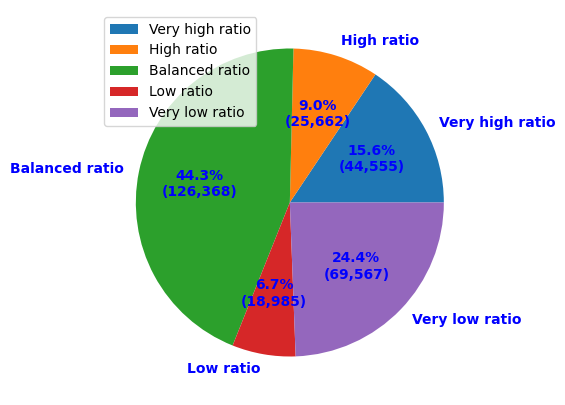

In [ ]:
plt.figure(figsize=(10, 5))


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{:.1f}%\n({v:,d})'.format(pct, v=val)  # Show percentage and count
    return my_format

plt.pie(
    result.values(),
    labels=[k.replace("_", " ").capitalize() for k in result.keys()],
    autopct=autopct_format(result.values()),
    textprops=dict(color="b", weight="bold")  # TODO: make it white and remove floating labels
)

plt.legend()

plt.plot()

In [27]:
driver.close()